# Introduction

There are many reasons people move to large cities. They might move because they have a better job opportunity, or because there are more options for professionals in areas with a greater concentration of offices and people. If you live and work in the city, you generally enjoy lower commute times. Perhaps you may just be a people person and there is something about being surrounded by people 24/7 that attracts you to high-density areas.

A reason often cited for going to cities is the proximity to good entertainment, food and attractions. In a higher population area, it makes sense that there would be more businesses open to service the population. However, some people go further and paint the increase in attractions as a reflection of the cultural diversity within an area. Since a higher number of businesses increases tourism and traffic to an area (and tourism and traffic increase the profitability of opening new businesses), this goes to say that cultural diversity can be beneficial to a city's economy.

This study will examine Toronto location and demographic data to determine if the number of businesses open in an area are in fact a result of demographic diversity. We will do this by seeing if there is an impact of population characteristics (i.e. population, age, income and language as a measure of cultural diversity) on the number of restaurants in an area. If, after controlling for population density, there are still significant impacts of age, income and cultural diversity, then this could indicate that there is some value to be found in incentivizing certain groups to move to cities.

# Data

We will be using four main data sources:

**1) List of Toronto neighbourhoods and postal codes, scraped from Wikipedia. Here is the [url](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).**

This table contains all Toronto postal codes starting with M (hereby known as boroughs) and the underlying neighbourhoods. These data were retrieved from the Canada Post website, according to the Wikipedia citations.

**2) Latitude and Longitude coordinates for Toronto neighbourhoods**

This dataset was provided by IBM and lists the latitude and longitude coordinates for each of the Toronto neighbourhoods. It can be found in a CSV file.

**3) Foursquare location data, retrieved through an API.**

These data contain venue locations according to each of the neighbourhood latitude and longitude coordinates obtained in the second dataset.

**4) Toronto Census Data. Here is the [url](https://open.toronto.ca/dataset/neighbourhood-profiles/).**

This dataset can be downloaded off the City of Toronto website and contains aggregated demographic data on each of the city's neighbourhoods. Collected in 2016, this data was collected at the last nationwide census and includes information such as age, gender, languages spoken, income and population. Age, languages spoken and income are represented as percentage of the total respondents.

The overall dataset is a cross-section of 20 neighbourhoods that appear both in the list of Toronto neighbourhoods and postal codes and in the census data (the boroughs in both are divided slightly differently).


# Methodology

We run an OLS regression to determine the impact of demographic factors on the number of restaurants in an area.

${Restaurants}_{j} = {\beta}_{1}popdensity_{j} + {\beta}_{2}ageyoung_{j} + {\beta}_{3}inchigh_{j} + {\beta}_{4}langforeign_{j} + {\epsilon}_{j} $

where *j* is a neighbourhood in Toronto, *popdensity* is the population density per square km, *ageyoung* is the proportion of all individuals between 15 and 55 years old, *inchigh* is the proportion of households making over $50000/year and *langforeign* is the proportion of individuals not speaking English or French as a first language.

# Install all packages

In [2]:
!pip install requests
!pip install html5lib
!pip install bs4
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
from sklearn import linear_model
from sklearn import metrics

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Scrape datasets - Toronto

In [26]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = requests.get(URL)
soup = BeautifulSoup(html.content, 'html5lib')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df_toronto =pd.DataFrame(table_contents)
df_toronto['Borough']=df_toronto['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

lat_lon = pd.read_csv(r"C:\Users\siqm\Downloads\Geospatial_Coordinates.csv")
lat_lon = lat_lon.rename(columns = {'Postal Code': 'PostalCode'})

df_toronto = pd.merge(df_toronto, lat_lon, on = 'PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


# Toronto Census Data for Income, Age, Languages and Population

In [27]:
census_data = pd.read_csv(r"C:\Users\siqm\Downloads\toronto_data.csv")
census_data.dropna(how='all', axis=1, inplace=True)

df_toronto = pd.merge(df_toronto, census_data, on = 'Neighborhood')
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Pop_density,Age_0_14,Age_15_24,Age_25_54,Age_55_64,...,Inc_45000_49999,Inc_50000_59999,Inc_60000_69999,Inc_70000_79999,Inc_80000_89999,Inc_90000_99000,Inc_100000_199999,Inc_200000,Inc_0_50000,Inc_50000_over
0,M3A,North York,Parkwoods,43.753259,-79.329656,4691,0.164,0.131,0.415,0.120,...,0.045272,0.087623,0.074845,0.064257,0.057685,0.047463,0.277108,0.064987,0.326031,0.673969
1,M4A,North York,Victoria Village,43.725882,-79.315572,3710,0.146,0.112,0.397,0.126,...,0.059901,0.090204,0.080338,0.069063,0.054264,0.040874,0.203665,0.033827,0.427766,0.572234
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,16880,0.150,0.163,0.513,0.101,...,0.044539,0.083775,0.076352,0.054083,0.046660,0.037116,0.158006,0.031813,0.512195,0.487805
3,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,7682,0.148,0.110,0.478,0.113,...,0.042254,0.071831,0.060563,0.050704,0.038732,0.033803,0.288028,0.131690,0.324648,0.675352
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,6058,0.175,0.095,0.439,0.144,...,0.025821,0.044639,0.039825,0.038950,0.037637,0.035449,0.414880,0.198249,0.190372,0.809628


# Get all venues from Foursquare API

In [7]:
CLIENT_ID = 'CVSUDURB54AQFHZE55RFYO3QT5Z4DZCFYZMNWWYNCCR2KKRZ' # your Foursquare ID
CLIENT_SECRET = 'LUSTZ5KPZFXKXXD44FLGB1GORLIBYUOOX5JV5B2JFME1ZMCH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
# Find number of venues for each neighbourhood
toronto_data = {}
toronto_venues = {}
for name in df_toronto["Borough"].unique():   
    toronto_data[name] = df_toronto[df_toronto['Borough'].str.contains(name)].reset_index(drop=True)

    toronto_venues[name] = getNearbyVenues(names=toronto_data[name]['Neighborhood'],
                                   latitudes=toronto_data[name]['Latitude'],
                                   longitudes=toronto_data[name]['Longitude']
                                  )

Parkwoods
Victoria Village
Hillcrest Village
Bayview Village
Humber Summit
Willowdale West
Regent Park, Harbourfront
Parkwoods
Victoria Village
Humewood-Cedarvale
Hillcrest Village
Thorncliffe Park
Bayview Village
Humber Summit
Weston
Willowdale West
The Beaches
Woburn
Scarborough Village
Thorncliffe Park


# Limiting to Just Artistic Venues

In [29]:
toronto_onehot = {}
toronto_grouped = {}
col = {}
matching = {}

for name in df_toronto["Borough"].unique(): 
    # one hot encoding
    toronto_onehot[name] = pd.get_dummies(toronto_venues[name][['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    toronto_onehot[name]['Neighborhood'] = toronto_venues[name]['Neighborhood'] 

    toronto_grouped[name] = toronto_onehot[name].groupby('Neighborhood').mean().reset_index()
    
    # Merge raw data with venues data
    toronto_grouped[name] = pd.merge(toronto_data[name], toronto_grouped[name], on = 'Neighborhood')
    
    # Keep artistic venues only
    col[name] = list(toronto_grouped[name].columns.values)
    matchers = ['Restaurant','Neighborhood','Lan','Inc','Pop','Age']
    #matchers = ['Art','Neighborhood','Record','Entertainment','Dance','Jazz','Venue','Sculpture',\
                #'Opera','Theater','Speakeasy','Book','Lan','Inc','Pop','Age'] # Not enough art venues
    matching[name] = [s for s in col[name] if any(xs in s for xs in matchers)]
    
    toronto_grouped[name] = toronto_grouped[name][matching[name]]
    
toronto_grouped['North York'].head()

,Neighborhood,Pop_density,Age_0_14,Age_15_24,Age_25_54,Age_55_64,Age_65_84,Age_85,Age_young,Age_old,...,Inc_100000_199999,Inc_200000,Inc_0_50000,Inc_50000_over,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Japanese Restaurant,Mediterranean Restaurant,Portuguese Restaurant
0,Parkwoods,4691,0.164,0.131,0.415,0.120,0.148,0.022,0.711,0.289,...,0.277108,0.064987,0.326031,0.673969,0.00,0.250000,0.0,0.00,0.000000,0.0
1,Victoria Village,3710,0.146,0.112,0.397,0.126,0.188,0.032,0.654,0.346,...,0.203665,0.033827,0.427766,0.572234,0.00,0.000000,0.2,0.00,0.000000,0.2
2,Hillcrest Village,3148,0.121,0.124,0.345,0.129,0.245,0.036,0.590,0.410,...,0.351030,0.076070,0.296355,0.703645,0.00,0.166667,0.0,0.00,0.166667,0.0
3,Bayview Village,4195,0.110,0.114,0.469,0.115,0.164,0.028,0.692,0.308,...,0.299652,0.085117,0.323046,0.676954,0.25,0.000000,0.0,0.25,0.000000,0.0
4,Humber Summit,1570,0.170,0.136,0.383,0.104,0.188,0.020,0.688,0.312,...,0.247449,0.029337,0.375000,0.625000,0.00,0.000000,0.0,0.00,0.000000,0.0


# Append each borough's dataset to make one Toronto dataset

In [39]:
boroughs = list(toronto_grouped.keys())
first = boroughs[0]
print(boroughs)
boroughs.pop(0)

df_combined = toronto_grouped[first]

for b in boroughs:
    df_combined = df_combined.append(toronto_grouped[b])


['North York', 'Downtown Toronto', 'York', 'East Toronto', 'Scarborough', 'East York']


# Collapse into the number of restaurants per neighbourhood

In [40]:
cols_restaurants = [col for col in df_combined if col.endswith('aurant')]
df_combined['Sum'] = df_combined[cols_restaurants].sum(axis=1)

df_combined.drop(cols_restaurants, axis=1, inplace = True) # Drop extra columns
df_combined.drop_duplicates(inplace = True)
df_combined.head()

,Neighborhood,Pop_density,Age_0_14,Age_15_24,Age_25_54,Age_55_64,Age_65_84,Age_85,Age_young,Age_old,...,Inc_50000_59999,Inc_60000_69999,Inc_70000_79999,Inc_80000_89999,Inc_90000_99000,Inc_100000_199999,Inc_200000,Inc_0_50000,Inc_50000_over,Sum
0,Parkwoods,4691,0.164,0.131,0.415,0.120,0.148,0.022,0.711,0.289,...,0.087623,0.074845,0.064257,0.057685,0.047463,0.277108,0.064987,0.326031,0.673969,0.250000
1,Victoria Village,3710,0.146,0.112,0.397,0.126,0.188,0.032,0.654,0.346,...,0.090204,0.080338,0.069063,0.054264,0.040874,0.203665,0.033827,0.427766,0.572234,0.400000
2,Hillcrest Village,3148,0.121,0.124,0.345,0.129,0.245,0.036,0.590,0.410,...,0.059429,0.055468,0.064184,0.049128,0.048336,0.351030,0.076070,0.296355,0.703645,0.333333
3,Bayview Village,4195,0.110,0.114,0.469,0.115,0.164,0.028,0.692,0.308,...,0.064709,0.065207,0.061224,0.051767,0.049278,0.299652,0.085117,0.323046,0.676954,0.500000
4,Humber Summit,1570,0.170,0.136,0.383,0.104,0.188,0.020,0.688,0.312,...,0.084184,0.082908,0.068878,0.065051,0.047194,0.247449,0.029337,0.375000,0.625000,0.000000


# Some Tables

In [41]:
byneighborhood = df_combined.groupby('Neighborhood')[['Neighborhood','Pop_density', 'Age_young', 'Age_old', \
                                                      'Lang_native', 'Lang_foreign', 'Inc_0_50000', 'Inc_50000_over', \
                                                     'Sum']]
byneighborhood.head()

,Neighborhood,Pop_density,Age_young,Age_old,Lang_native,Lang_foreign,Inc_0_50000,Inc_50000_over,Sum
0,Parkwoods,4691,0.711,0.289,0.971691,0.028165,0.326031,0.673969,0.250000
1,Victoria Village,3710,0.654,0.346,0.957546,0.041873,0.427766,0.572234,0.400000
2,Hillcrest Village,3148,0.590,0.410,0.906915,0.092199,0.296355,0.703645,0.333333
3,Bayview Village,4195,0.692,0.308,0.956000,0.044000,0.323046,0.676954,0.500000
4,Humber Summit,1570,0.688,0.312,0.919790,0.079807,0.375000,0.625000,0.000000
5,Willowdale West,5820,0.653,0.347,0.942274,0.058022,0.357284,0.642716,0.000000
0,"Regent Park, Harbourfront",16880,0.827,0.173,0.941039,0.058961,0.512195,0.487805,0.113636
2,Humewood-Cedarvale,7682,0.736,0.264,0.986653,0.013347,0.324648,0.675352,0.000000
4,Thorncliffe Park,6787,0.793,0.207,0.936466,0.064013,0.500000,0.500000,0.190476
7,Weston,7197,0.713,0.287,0.963611,0.036671,0.480647,0.519353,0.000000


# Some Plots

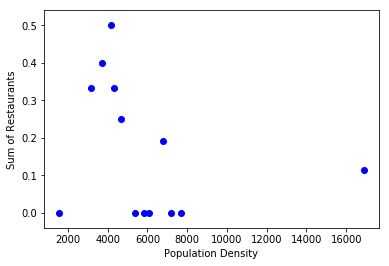

In [42]:
plt.scatter(df_combined.Pop_density, df_combined.Sum,  color='blue')
plt.xlabel("Population Density")
plt.ylabel("Sum of Restaurants")
plt.show()

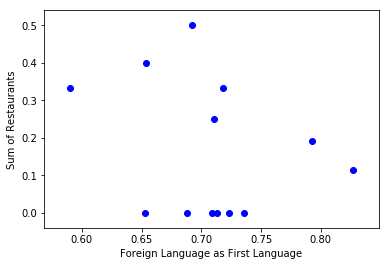

In [43]:
plt.scatter(df_combined.Age_young, df_combined.Sum,  color='blue')
plt.xlabel("Foreign Language as First Language")
plt.ylabel("Sum of Restaurants")
plt.show()

# Summary Statistics

There does not seem to be any correlation between each of the individual regressors and the sum of restaurants in each neighbourhood. From the summary statistics from each neighbourhood, each neighbourhood seems fairly balanced.

# Regression Analysis

In [45]:
# Regress number of restaurants on population density, age dummies, language dummies and income dummies
regr = linear_model.LinearRegression()
x = np.asanyarray(df_combined[['Pop_density','Age_young','Lang_foreign', 'Inc_50000_over']])
y = np.asanyarray(df_combined[['Sum']])

regr.fit (x, y)

# The coefficients
print ('Coefficients: ', regr.coef_)

# Model Evaluation
y_hat= regr.predict(df_combined[['Pop_density','Age_young','Lang_foreign', 'Inc_50000_over']])
r2 = metrics.r2_score(y, y_hat)

# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2)
print('Variance score: %.2f' % regr.score(x, y))


Coefficients:  [[-8.59909969e-06 -2.82006477e-01  1.44938391e+00 -9.18833997e-03]]
R-squared: 0.12
Variance score: 0.12


# Results

Somewhat unexpectedly, there is a small, but negative coefficient on population density. This means that the higher the amount of people living in a given area, the less restaurants there tend to be. We would expect for there to be more restaurants in higher density areas, however after controlling for income age and culture, this is not the case.

There is also a negative coefficient on younger neighbourhoods. In neighbourhoods where there is a higher proportion of young people, there is a small and negative impact on the number of restaurants in the area. This again can be counterintuitive - younger people are known for going out more, however they may have less disposable income. It could also be that younger people do not tend to stay in their own areas and are more likely to experience different parts of the city. As result, you would not see a positive correlation between restaurants and more youthful areas.

There is also a negative coefficient on higher income areas. The higher the proportion of income over $50000, the lower the number of restaurants in the area. Perhaps these areas could be more residential or more selective over the type of establishments that can set up shop. Wealthier individuals may also be more prone to leaving their neighbourhood to purchase food.

All of the coefficients mentioned above were relatively small, however the largest coefficient belonged to the higher proportion of those without English or French as a first language. Having a higher number of ethnically diverse constituents within the neighbourhood has a positive impact on the number of restaurants in a neighbourhood. This could be explained by those who do not speak an official language well choosing to open up their own businesses instead of pursuing the job market. Those with different cultural backgrounds also tend to fare better in the restaurant business due to them having a unique cuisine and thus selling point.

Unfortunately, the R-squared (explainability) of the model is still fairly low - it is only 0.12. This means that there are other covariates that we are missing that could serve to explain the model.

# Conclusion

Overall, we do not see a strong impact of demographic factors on the number of restaurants in a neighbourhood except for the proportion of people who speak a foreign language which has a positive impact. The model has low explainability which may indicate that there are covariates that are missing. For example, places with many offices or easy access to transit may have more businesses and restaurants due to a larger customer base. As well, crime rates, tax policies and rents may also affect the number of restaurants in an area.

Another factor is the standard supply and demand equation. Within a specific area, there is space allocated to residential, commercial and industrial spaces. If the development in the area is largely residential, the supply of land may not be enough to satisfy the demand for restaurant spaces.

Overall, the results from this study indicate that increased cultural diversity could play a role in increasing the number of restaurants in an area and thus increasing economic activity. Economically, having a greater choice of places to eat can increase the social welfare of people living and visiting a particular neighbourhood so that cultural diversity is a positive. This supports the agenda of immigration and multiculturalism being beneficial for the economy. In order to make the findings more robust, policy-makers will have to include more controls and experiment with various regression forms, however this makes the case that there should be more study in this area.